# Physics 129 Fall 2025 Homework 3 

**Due Friday September 26 11:59PM**

submit the PDF version of the complete notebook to GradeScope

## Question 1: Fitting a Signal in the Presence of Background (30 points)

### Learning objectives
In this question you will:

- Gain experience in performing $\chi^2$ fits to histogrammed data; explore how the statistical significance of a signal depends on the number of signal events and the signal-to-background ratio


### 1a. 

Physicists often fit for signals in the presence of background.  In such cases, the significance of the fitted signal depends not only on the number of signal events but also on the amount of background and our ability to statistically separate the two.  In this problem, we will explore fitting signal and background for a very simple case:  The signal is a Gaussian peak centered at $x=10$ with a width $\sigma=1$ and the background is uniformly distributed between $x=0$ and $x=20$.  The code below generates fake data, allowing you to change both the number of events in the signal and the ratio of signal-to-background.  To make sure that our definition of background does not depend on the fit range, the code below defines the signal-to-background ratio as the ratio number of signal events to the number of background events in a $\pm 2 \sigma$ window around the signal peak.  Here is the code you will use to generate the fake data:

In [2]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def makeData( SignalToBackground, nSigEvents, seed=12345):
    """Generates a dataset consisting of nEvents some of which are signal (a Gaussian with a width of 1 centered
    at x=5) and the rest of which is background
    Definition of SignalToBackground:  The ratio of the number of signal events within 2 sigma of the peak to the number
    of background events in that same x-range  (this definition is just a choice)
    
    Parameters
    ==========
     SignalToBackground : float
     Ratio of the number of signal events within 2 sigma of the peak to the number
    of background events in that same x-range  (this definition is just a choice) 
      
    nSigEvents : int
      total number of signal events generated (NOT the number in +- 2 sigma)
      
    seed : int
      seed for the random number generator
      
    Returns
    =======
    data : array
      the measurements of x
    """
    fracOutsideTwoSigma = 4.55e-2
    # 1-fracOutsideTwoSigma is the fraction of the Signal Events within +-2 sigma
    # To get the total number of background events, find the number in +-2 sigma
    # which is 4 units of x and then since the background is flat from 0 to 20
    # multiply by 20/4=5
    
    nBackground = 5*nSigEvents*(1-fracOutsideTwoSigma)/SignalToBackground
    nEvents = nSigEvents+nBackground
    fSig = nSigEvents/nEvents
    
    # Make an array to hold the data (ie the x measurements)
    data = []
    
    # set the random seed.  This will allow us to reproduce the results if we run again
    np.random.seed(seed)
 
    # Retrieve nEvents random numbers that will be used to pick which events are signal
    # and which are background
    n = int(nEvents)
    tests = np.random.uniform(0,1,n)
    bck = np.random.uniform(0,20,n)
    sig = np.random.normal(10,1,n)
    
    count = 0
    for test in tests:
        if(test<fSig):
            data.append(sig[count])
        else:
            data.append(bck[count])
        count+=1
    
    # Loop over the events and pick either signal or background and draw from the appropriate 
    # pdf in each case
    
    # return the data to the user
    return data
    

Below is a simple test to show you how to use this code.  Remember if you run this code multiple times you should change the seed each time (for example, you could increment the seed each time you call the function)

In [14]:
mydata = []
#  make 10 signal events with a signalToBackground of 1 using random seed 123
mydata=makeData(1,20,123)
print("number of total data events: ",len(mydata))
print("data: ",mydata)

number of total data events:  115
data:  [np.float64(11.047401505881462), np.float64(11.57102936217666), np.float64(10.430661187946646), np.float64(0.05376129148641384), np.float64(19.7669083856564), np.float64(18.106831513232198), np.float64(4.15271722392649), np.float64(5.849788255848496), np.float64(10.40020306144967), np.float64(18.038227453213413), np.float64(19.672617698234465), np.float64(5.150841283081662), np.float64(11.287180858495633), np.float64(10.579689779144333), np.float64(7.887401079055496), np.float64(14.621460716891141), np.float64(3.221380288584297), np.float64(12.013971356671798), np.float64(17.317289166065294), np.float64(19.67043218407111), np.float64(1.5873158075603144), np.float64(8.566945494018984), np.float64(4.0908571909285545), np.float64(9.012729810374696), np.float64(10.95527145257708), np.float64(1.8665342073964153), np.float64(5.937215509613589), np.float64(18.55168480304295), np.float64(11.380074628603907), np.float64(9.148239950472238), np.float64(8.7

Generate a sample of 1000 signal events with signalToBackground=0.5 and make a histogram of your results. Make sure that the number of bins in your histogram is small enough that you have at least 10 entries per bin (so that it is reasonable to do a binned fit to the histogram). To make life a bit easier, here is function you can use to make your histograms.  You are of course free to write your own function and not use this code.

In [41]:
#Import the pyplot module of matplotlib as "plt"
import matplotlib.pyplot as plt


#Makes a histogram filled with the random numbers we generate
def plot_histogram(samples,xtitle,ytitle, title, nbins, limits):
    print('before denoising')
    #Plot the histogram of the sampled data with nbins and a nice color
    n, bins, patches =plt.hist(samples, bins=nbins, range=limits, color='red', label = 'data')  #Set the color using (r,g,b) values or
                                                                  #  use a built-in matplotlib color""" 
    bincenters = 0.5*(bins[1:]+bins[:-1])
    errs = np.sqrt(n)

    plt.errorbar(bincenters, n, yerr=errs, fmt='none', color = 'blue', label = 'error = sqrt(data)')
    #Add some axis labels and a descriptive title
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)

    #Get rid of the extra white space on the left/right edges (you can delete these two lines without a problem)
    xmin, xmax, ymin, ymax = plt.axis()
    plt.axis([limits[0],limits[1],ymin,ymax])
    plt.legend()

    #Not necessarily needed in a Jupyter notebook, but it doesn't hurt
    plt.show()
    return n, bins, patches


# Since we know that background events dominate away from the bell curve, in order to denoise the histogram, we take the average number
# of events at the first few and last few bins, and subtract that number from all of the bins, leaving us with the top half of the gaussian curve

def plot_histogram_denoised(samples, xtitle, ytitle, title, nbins, limits):
    print('after denoising')
    n, bins = np.histogram(samples, bins=nbins, range=limits)
    bincenters = 0.5 * (bins[1:] + bins[:-1])

    ext_bins = int(nbins * 0.3)  

    sum_events = n[:ext_bins].sum() + n[-ext_bins:].sum()
    avg_bkg = sum_events / (2 * ext_bins)

    # Subtract average background from each bin
    n_denoised = n - avg_bkg
    n_denoised[n_denoised < 0] = 0  #debugging from CHATGPT

    errs = np.sqrt(n_denoised)

    #plot
    plt.bar(bincenters, n_denoised, width=bins[1]-bins[0], color='red', label='data - avg bkg')
    plt.errorbar(bincenters, n_denoised, yerr=errs, fmt='none', color='blue', label='error = sqrt(data)')
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)
    plt.title(title)
    plt.axis([limits[0], limits[1], min(0, n_denoised.min()), max(n_denoised.max(), 1)])
    plt.legend()
    plt.show()

    return n_denoised, bins



before denoising


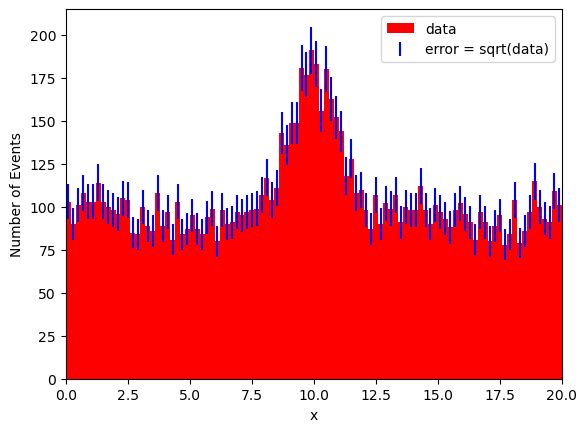

after denoising


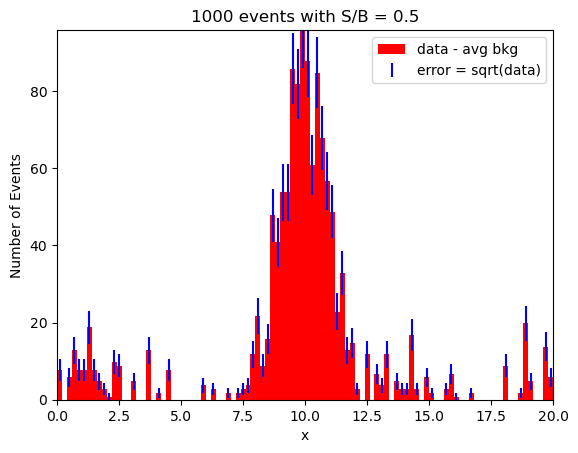

In [42]:
data = []
mydata = makeData(0.5,1000,1234)
s_exp = []
s_meas = []
# print("number of total data events: ",len(mydata))
hist_data = plot_histogram(mydata, 'x', 'Number of Events', '1000 events with S/B = 0.5', int(len(mydata)/(len(mydata)*0.01)), [0,20])
hist_data_denoised = plot_histogram_denoised(mydata, 'x', 'Number of Events', '1000 events with S/B = 0.5', int(len(mydata)/(len(mydata)*0.01)), [0,20])



    

### 1b. 

Pretend this is real data.  Your goal is to find the best estimate of how many events are in a Gaussian peak with unknown mean and sigma and what the uncertainty on this estimate is.  In your fit, you can make the assumption that the background is flat (a zeroth order polynomial) but that you don't have a prediction for the background rate.  Use your favorite minimization package to fit the data.  Deterimine the best estimate of the number of events in signal and the uncertainty on that estimate.  (remember, that you must let the position and width of the Gaussian and the size of the background vary in your fit).

Hint: For examples of how to perform a least squared fit of a function to data see:
- https://github.com/berkeley-physics/Python-Tutorials/blob/master/3%20-%20Specific%20topics/Fitting.ipynb
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

[86.93205172  9.99541226  0.94116214 95.19574021]
[[ 1.40513383e+01  1.43639503e-08 -8.69114535e-02 -7.10515064e-01]
 [ 1.43639503e-08  2.11740897e-03 -1.50148847e-10 -1.24222046e-11]
 [-8.69114535e-02 -1.50148847e-10  2.35295696e-03 -1.53845155e-02]
 [-7.10515064e-01 -1.24222046e-11 -1.53845155e-02  1.00482004e+00]]


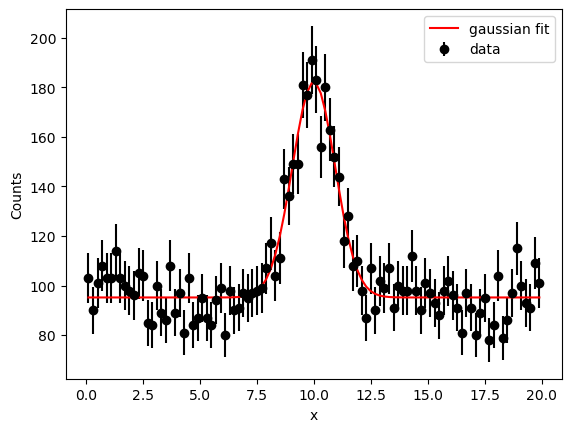

A     = 86.93 ± 3.75
mu    = 10.00 ± 0.05
sigma = 0.94 ± 0.05
B     = 95.20 ± 1.00
Signal events ≈ 205.1 ± 13.8


In [43]:
from scipy.optimize import curve_fit
# def polyFit(data, bins, df):
#     mu_fit = np.polyfit(bins, data, df)
#     model_mesh = np.polyval(mu_fit, bins) 
#     print(mu_fit)
#     plt.bar(bins, data, width= bins[1]-bins[0], align='center', edgecolor='black')
#     plt.plot(bins, model_mesh, c="b", label="polynomial fit")

counts = hist_data[0]
edges  = hist_data[1]
x = 0.5*(edges[1:] + edges[:-1])
y = counts

# polyFit(y, x, 15)


def gauss_plus_const(x, A, mu, sigma, B):
    return A * np.exp(-(x-mu)**2/(2*sigma**2)) + B # the constant B will account for the non denoising factor


def normalFit(y, x):
    yerr = np.sqrt(y)
    popt, pcov = curve_fit(gauss_plus_const, x, y)
    print(popt)
    print(pcov)

    perr = np.sqrt(np.diag(pcov))  

    plt.errorbar(x, y, yerr=yerr, fmt='o', color='black', label='data')
    plt.plot(x, gauss_plus_const(x, *popt), 'r-', label='gaussian fit')
    plt.xlabel("x")
    plt.ylabel("Counts")
    plt.legend()
    plt.show()


    
    #formatting from CHATGPT
    print(f"A     = {popt[0]:.2f} ± {perr[0]:.2f}")
    print(f"mu    = {popt[1]:.2f} ± {perr[1]:.2f}")
    print(f"sigma = {popt[2]:.2f} ± {perr[2]:.2f}")
    print(f"B     = {popt[3]:.2f} ± {perr[3]:.2f}")

    N_signal = popt[0] * np.sqrt(2*np.pi) * popt[2]
  
    N_err = N_signal * np.sqrt( (perr[0]/popt[0])**2 + (perr[2]/popt[2])**2 )
    print(f"Signal events ≈ {N_signal:.1f} ± {N_err:.1f}")

    return popt, perr, N_signal

popt, perr, N_meas = normalFit(y, x)

### 1c. 

What is the $\chi^2$ per degree of freedom for your fit?  What does this number tell you about how well your fit describes the data?

In [44]:
def chiSquared(func, meas, dof):
    exp_vals = func
    meas_vals = meas
    sigma = np.sqrt(meas)

    chi_squared_val = np.sum(((exp_vals-meas_vals)**2)/(sigma**2))/dof
    return chi_squared_val
# free parameters = 4
A = popt[0]
mu = popt[1]
stdv = popt[2]
B = popt[3]
meas = y
f = 0.5
dof = len(meas) - 4
print(N_meas)
print(perr[0])
func = gauss_plus_const(x, A, mu, stdv, B)
print('the chi squared value is:')
print(float(chiSquared(func, meas, dof)))

print('The measured significance is:')
S_meas = N_meas/perr[0]
print(S_meas)
print('The expected significance is:')
N_total = len(mydata)
N_s = f * N_total
N_b = N_total - N_s
S_expected = N_s / np.sqrt(N_s + N_b)
print(S_expected)

s_meas.append(S_meas)
s_exp.append(S_expected)
print(s_meas)
print(s_exp)

205.0851958775627
3.7485114792139163
the chi squared value is:
0.7439142842243457
The measured significance is:
54.71110253090921
The expected significance is:
51.34442520858521
[np.float64(54.71110253090921)]
[np.float64(51.34442520858521)]


My chi-squared value is 0.7439 so therefore the gaussian model explains the data fairly well. If we generate way more events, we should expect the Chi squared value to be closer to 1. 

### 1d. 

If a signal of size $N_S^{meas}$ has a fitted uncertainty $\sigma_S$, the signficance of the measurement is defined to be
$$
S^{meas} \equiv \frac{N_S^{meas}}{\sigma_S}
$$
When the size of the data sample is large enough that Gaussian uncertainties are appropriate, a rule of thumb can be used to give a crude estimate of the expected significance $S^{expected}$ of the measurement. This predicted signficance depends on the number of signal events ($N_{S}$) and is the number of background events populating the region **beneath the signal** ($N_B$):
$$
S^{expected}  \approx  \frac{N_S}{\sqrt{N_S+N_B}}
$$

Repeat the above exercise changing both the number of events in your signal and the signalToBackground ratio.  Plot the values of the measured significance  $S^{meas}$ 
obtained from your fits as a function of $\frac{N_S}{\sqrt{N_S+N_B}}$.  How do your results compare to the simple rule of thumb quoted above?

number of total data events:  169083
before denoising


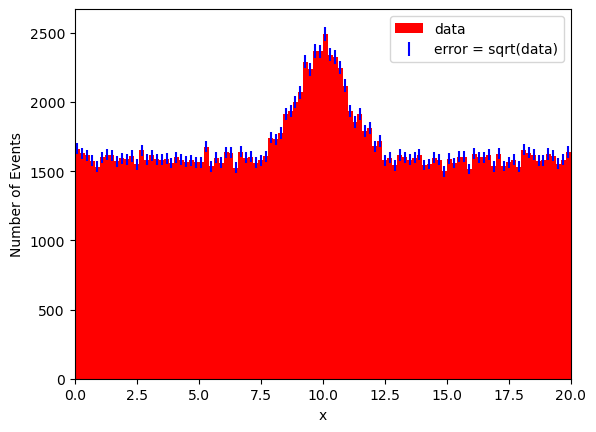

[8.09655106e+02 9.99988444e+00 9.98507219e-01 1.58950626e+03]
[[ 3.13302241e+02  3.56077483e-08 -2.17806981e-01 -1.71057927e+01]
 [ 3.56077483e-08  6.10802339e-04 -4.85839427e-11  5.11708741e-10]
 [-2.17806981e-01 -4.85839427e-11  6.84386723e-04 -4.21912036e-02]
 [-1.71057927e+01  5.11708741e-10 -4.21912036e-02  2.41912437e+01]]


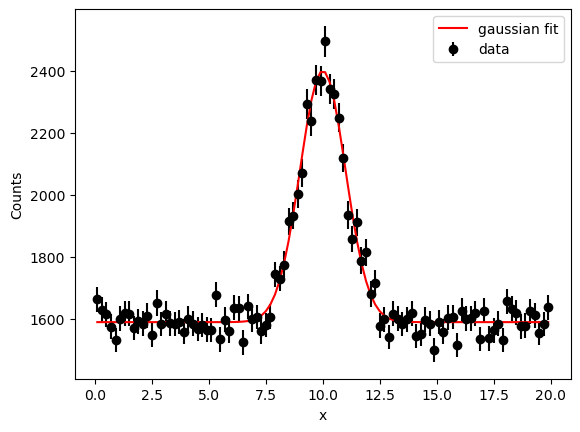

A     = 809.66 ± 17.70
mu    = 10.00 ± 0.02
sigma = 1.00 ± 0.03
B     = 1589.51 ± 4.92
Signal events ≈ 2026.5 ± 69.1
17.70034578939226
The measured significance is:
114.487863785442
The expected significance is:
123.35910991896787
[np.float64(54.71110253090921), np.float64(114.487863785442), np.float64(114.487863785442)]
[np.float64(51.34442520858521), np.float64(123.35910991896787), np.float64(123.35910991896787)]


Text(0.5, 1.0, 'Expected Significance v.s. Measured significance')

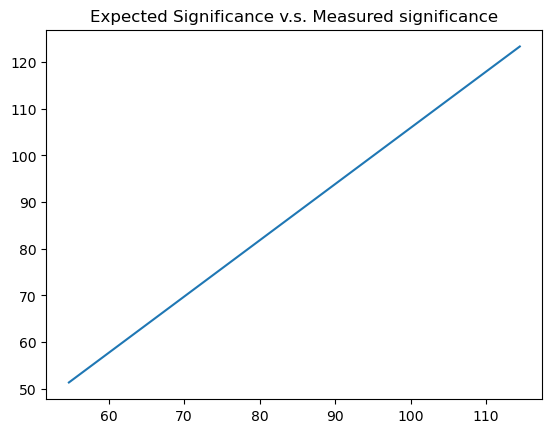

In [46]:
data = []
mydata = makeData(0.3,10000,12345)
f = 0.3
print("number of total data events: ",len(mydata))
hist_data = plot_histogram(mydata, 'x', 'Number of Events', '1000 events with S/B = 0.5', int(len(mydata)/(len(mydata)*0.01)), [0,20])
counts = hist_data[0]
edges  = hist_data[1]
x = 0.5*(edges[1:] + edges[:-1])
y = counts
popt, perr, N_meas = normalFit(y, x)
A = popt[0]
mu = popt[1]
stdv = popt[2]
B = popt[3]
meas = y
dof = len(meas) - 4

func = gauss_plus_const(x, A, mu, stdv, B)
float(chiSquared(func, meas, dof))
print(perr[0])
print('The measured significance is:')
S_meas = N_meas/perr[0]
print(S_meas)
print('The expected significance is:')
N_total = len(mydata)
N_s = f * N_total
N_b = N_total - N_s
S_expected = N_s / np.sqrt(N_s + N_b)
print(S_expected)

s_meas.append(S_meas)
s_exp.append(S_expected)
print(s_meas)
print(s_exp)

plt.plot(s_meas, s_exp)
plt.title('Expected Significance v.s. Measured significance')

    

In [ ]:
My results are very similar to the rule of thumb, where the discrepancy decreases as i increase the humber of events.

## Question 2: Noether's Theorem (20 points)

### Learning objectives
In this question you will:

- Review the meaning of Noether's theorem
- Apply Noether's theorm to a non-relativistic quantum mechanical example 

In non-relativistic quantum mechanics, we learned that if an operator commutes with the Hamiltonian, the expectation value of that operator is a conserved quantity.  The same concept holds in relativistic quantum mechanics but is expressed using Lagrangian language.  The Lagrangian can be expressed as $$ L = T - V$$ where $T$ is the kinetic energy of the system and $V$ is the potential energy of the system. The action, S, of a trajectory is defined as the integral of the Lagrangian with respect to time during the trajectory, i.e. $$ S = \int L \hspace{0.05in} dt $$.

Noether's theorem tells us that for every symmetry of the action there is a conserved quantum number.

Consider the following example for the case of non-relativisitic quantum mechanics.  A particle with spin-$\frac{1}{2}$ and magnetic moment $\vec \mu = g \frac{q}{2m} \vec S$ where $q$ is the charge of the particle and $\vec S$ is the spin is placed in a constant magnetic field in the $z$-direction $\vec B = B_0 \hat z$.  The Lagrangian is therefore
$$
L = \frac{\left ( \vec p \right ) ^2}{2m}  + \vec \mu \cdot B
$$
Which of the following are conserved quantities:
- (a) $p_x$, the $x$-component of the momentum
- (b) $p_z$, the $z$-component of the momentum
- (c) $S_x$, the $x$-component of the spin
- (d) $S_z$, the $z$-component of the spin
- (e) $\vec S^2$ the magnitude of the spin-squared operator


$$
\mathcal{L} = \frac{\vec p^{\,2}}{2m} + \vec\mu \cdot \vec B
= \frac{\vec p^{\,2}}{2m} + \frac{gqB_0}{2m}S_z.
$$

From the Lagrangian we construct the Hamiltonian
$$
H = \frac{\vec p^{\,2}}{2m} + \frac{gqB_0}{2m}S_z
= \frac{1}{2m}\bigl(\vec p^{\,2} - gqB_0 S_z \bigr).
$$

---

### Checking if \(p_x\) is conserved

$$
[\hat H, p_x] = \hat H p_x - p_x \hat H.
$$

$$
[\hat H, p_x]
= \frac{1}{2m}\Bigl\{\vec p^{\,2}p_x + gqB_0 S_z p_x - p_x\vec p^{\,2} - gqB_0 p_x S_z\Bigr\}.
$$

Since
$$
[\vec p^{\,2},p_x]=0, \qquad [p_x,S_z]=0,
$$
we find
$$
[\hat H,p_x] = \frac{1}{2m}\Bigl\{\vec p^{\,2}p_x - p_x\vec p^{\,2}
+ gqB_0(S_zp_x - p_xS_z)\Bigr\} = 0.
$$

Because the commutator vanishes, \(p_x\) is a conserved quantity:
$$
\boxed{p_x \ \text{is conserved}.}
$$
### (b) Checking if \(p_z\) is conserved

$$
[\hat H, p_z] = \hat H p_z - p_z \hat H.
$$

Using the Hamiltonian
$$
\hat H = \frac{\vec p^{\,2}}{2m} + \frac{gqB_0}{2m}S_z
$$
$$
[\vec p^{\,2},p_z]=0, \qquad [S_z,p_z]=0 \quad \text{(they act on different spaces)},
$$
$$
[\hat H,p_z] = 0.
$$

Thus
$$
\boxed{p_z \ \text{is conserved}.}
$$

---

### (c) Checking if \(S_x\) is conserved

$$
[S_x,S_z] \ne 0.
$$

Since the Hamiltonian depends on \(S_z\),
$$
[\hat H,S_x] \ne 0,
$$
so
$$
\boxed{S_x \ \text{is not conserved}.}
$$

---
### (d) Checking if \(S_z\) is conserved

$$
[\vec p^{\,2},S_z] = 0, \qquad [S_z,S_z] = 0
$$
Hence
$$
[\hat H, S_z] = 0.
$$

Therefore
$$
\boxed{S_z \ \text{is conserved}.}
$$

---
### (e) Checking if \(S^2\) is conserved

$$
[\vec p^{\,2},S^2] = 0, \qquad [S_z,S^2] = 0
$$
because \(S^2\) commutes with all spin components and with momentum.  
Hence
$$
[\hat H, S^2] = 0.
$$

Therefore
$$
\boxed{S^2 \ \text{is conserved}.}
$$


## Question 3: Parity Properties of Various Operators (20 points)

### Learning objectives
In this question you will:

- Review the meaning of the terms vector, axial vector, scalar and pseudoscalar and determine the parity property of several operators

We saw in class that operators could be classified according to their properties under the parity operator.  Vector operators change sign under parity

$$
{\bf P}\; \vec r \; {\bf P}^\dagger \rightarrow - \vec r
$$

while axial vectors do not:

$$
{\bf P }\;\vec L \; {\bf P } ^\dagger \rightarrow + \vec L
$$

similarly, scalar operators do not change sign under parity 

$$
{\bf P}\; \left (\vec r \cdot \vec p \right ) \; {\bf P}^\dagger \rightarrow + \vec r \cdot \vec p
$$

while pseudoscalar operators do change sign:

$$
{\bf P}\; \left (\vec p \cdot \vec L \right ) \; {\bf P}^\dagger \rightarrow - \vec p \cdot \vec L 
$$

For each of the operators below, state whether they are scalar, pseudoscalar. vector or pseudovector:
- (a) $\vec p_1 \cdot \left (\vec p_2 \times \vec p_3 \right )$ where 1. 2 and 3 are three different particles
-(b)  $\vec p_1 \times \left (\vec p_2 \times \vec p_3 \right )$ where 1. 2 and 3 are three different particles
- (c) The magnetic moment $\vec \mu$ of a particle
- (d) The magnetic field $\vec B$\;\; (Hint: look at the Biot-Savart law)
- (e) $\left (\vec p_1 \times \vec p_2 \right) \cdot \left (\vec S_1+\vec S_2 \right)$ where 1 and 2 are two different particles


### (a)

$$
\mathbf P\bigl[\mathbf p_{1}\cdot(\mathbf p_{2}\times\mathbf p_{3})\bigr]\mathbf P^{\dagger}
$$

$$
\boldsymbol\alpha=\mathbf p_{1},\qquad
\boldsymbol\beta=\mathbf p_{2}\times\mathbf p_{3}
$$

$$
\boldsymbol\alpha\mapsto-\boldsymbol\alpha,\qquad
\boldsymbol\beta\mapsto+\boldsymbol\beta
$$

$$
\mathbf P(\boldsymbol\alpha\cdot\boldsymbol\beta)\mathbf P^{\dagger}
=(-\boldsymbol\alpha)\cdot(+\boldsymbol\beta)
=-,\boldsymbol\alpha\cdot\boldsymbol\beta
$$

$$
\boxed{P:\ \mathbf p_{1}\cdot(\mathbf p_{2}\times\mathbf p_{3})\mapsto-\mathbf p_{1}\cdot(\mathbf p_{2}\times\mathbf p_{3})}
$$
    
###Therefore it is a pseudoscalar
---

### (b)

$$
\mathbf P,[\mathbf p_{1}\times(\mathbf p_{2}\times\mathbf p_{3})],\mathbf P^\dagger
=(-\mathbf p_{1})\times(+,\mathbf p_{2}\times\mathbf p_{3})
=-,\mathbf p_{1}\times(\mathbf p_{2}\times\mathbf p_{3})
$$

$$
\boxed{P:\ \mathbf p_{1}\times(\mathbf p_{2}\times\mathbf p_{3})\mapsto-\mathbf p_{1}\times(\mathbf p_{2}\times\mathbf p_{3})}
$$

###Therefore it is a vector

---

### (c)

$$
\boldsymbol\mu=\frac{gq}{2m}\mathbf S
$$

$$
\mathbf P,\boldsymbol\mu,\mathbf P^{\dagger}=+\boldsymbol\mu
$$

$$
\boxed{P:\ \boldsymbol\mu\mapsto+\boldsymbol\mu}
$$
###Therefore it is a axial vector

---

### (d)

$$
\mathbf B=\frac{\mu_0}{4\pi}\int\frac{I,d\boldsymbol\ell\times\mathbf r}{r^{2}}
$$

$$
d\boldsymbol\ell\mapsto-,d\boldsymbol\ell,\qquad
\mathbf r\mapsto-,\mathbf r
$$

$$
d\boldsymbol\ell\times\mathbf r\mapsto(+),(d\boldsymbol\ell\times\mathbf r)
$$

$$
\boxed{P:\ \mathbf B\mapsto+\mathbf B}
$$
###Therefore it is a axial vector

---

### (e)

$$
\mathbf Z=\mathbf p_{1}\times\mathbf p_{2},\qquad
\boldsymbol\Sigma=\mathbf S_{1}+\mathbf S_{2}
$$

$$
\mathbf P(\mathbf Z\cdot\boldsymbol\Sigma)\mathbf P^{\dagger}=+\mathbf Z\cdot\boldsymbol\Sigma
$$

$$
\boxed{P:\ (\mathbf p_{1}\times\mathbf p_{2})\cdot(\mathbf S_{1}+\mathbf S_{2})\mapsto+(\mathbf p_{1}\times\mathbf p_{2})\cdot(\mathbf S_{1}+\mathbf S_{2})}
$$

###Therefore it is a scalar


## Question 4: Parity in Particle Decays (10 points)

### Learning objectives
In this question you will:

- Explore how conservation laws can be used to exclude specific decay channels

Show that a scalar meson (a meson with spin 0 and parity +1) cannot decay to three pseudoscalar mesons (mesons with spin 0 and parity -1) in a parity-conserving process such as the strong interaction.

### Q4. Parity in particle decays


- **Initial state:** $(P_i = +1)$.
- **Final state:** intrinsic parity $(P_f =(-1)^3 = -1)$.

The total parity of the final state is
$$
P_f = (-1)^3 \,(-1)^{\ell},
$$
where $\ell$ is the spin angular momentum which is 0 for pseudoscalars and 1 for vectors.

So $\ell=0+0+0$

So
$$
P_f = -1, \qquad P_i = +1.
$$

Since $(P_f\neq P_i)$ and parity is conserved in strong decays, this channel is forbidden.


### AI Technology Disclosure Statement

Use of AI technology is **permissible only** for:  
- Formatting answers (e.g., converting to Markdown or LaTeX)  
- Assisting with coding tasks (e.g., syntax help, debugging)  

Students must explicitly state **whether AI technology was used** in completing this homework.  
- If **yes**, describe **how** it was used.  
- If **no**, state that no AI technology was used.  

⚠️ If this disclosure is missing, the homework **will not be graded**.  
If it is later completed, the submission will be treated as **late**.


#### Your Answer

I used chatgpt to debug my code (where i commented) and to plot. I also used it to take my notes and convert it to a markdown form for questions 2,3 and 4.